In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [22]:
limitTrees =OrderedDict()
dataCards = OrderedDict()

limitTrees_obs =OrderedDict()
dataCards_obs = OrderedDict()
limitTrees_hybridNew = OrderedDict()
version = '/V1p17/v1/v75/'
version = '/V1p17/v2/v100/'
version = '/V1p17/v2/v106/'



dc_version = 'v9'
nrechit = 130
dphi = 'dPhiCluster0p75'

mode = 'allProd_withggZH'
# decay = '4Tau'
# decay = 'dddd'
decay = 'bbbb'



methodA = False
# unblind = 'unblindABC'
unblind = 'unblind'

bdt_name = 'cut_based_v4'
limitDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/'+version+'/'+bdt_name+'/'+dc_version+'/methodB/'
dataCardDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'+dc_version+'/methodB/'
hybridNewDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/hybridNew/'+version+'/'+bdt_name+'/'+dc_version+'/methodB/'+unblind+'/'


# if methodA:
#     limitDir+='methodA/'
#     dataCardDir+='methodA/'
#     hybridNewDir+='methodA/'
# else:
#     limitDir+='methodB/'
#     dataCardDir+='methodB/'
#     hybridNewDir+='methodB/'
lumi = 137000

ctaus = np.array([30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000, 30000, 50000, 100000])



if decay == 'bbbb': mass = np.array([ 15, 40, 55])
else:mass = np.array([ 7, 15, 40, 55])

### limit branch: 2.5, 16.0, 50.0, 84.0, 97.5, obs
expected = ['0.250', '0.160','0.500','0.840','0.975']
for m in mass:
    limitTrees[m] = {}
    dataCards[m] = {}
    limitTrees_hybridNew[m] = {}
    for ct in ctaus:
        name = mode+'_HToSSTo'+decay
        dataCards[m][ct] = dataCardDir + '/'+unblind+'/'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.txt'
        if unblind=='unblind':limitTrees[m][ct] = limitDir + '/'+unblind+'/obs/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.AsymptoticLimits.mH120.root'
        else:limitTrees[m][ct] = limitDir + '/'+unblind+'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.AsymptoticLimits.mH120.root'
        
        limitTrees_hybridNew[m][ct] = []
        for i in range(6):
            if i==5:limitTrees_hybridNew[m][ct].append(hybridNewDir +'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.HybridNew.mH120.root')
            else:limitTrees_hybridNew[m][ct].append(hybridNewDir +'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.HybridNew.mH120.quant'+expected[i]+'.root')
norms = []
limits = {}
limits_hybridNew = {}
for i,m in enumerate(limitTrees.keys()):
    limits[m] = np.ones((len(ctaus), 6))*1000000
    limits_hybridNew[m] = np.ones((len(ctaus), 6))*1000000

    for j, k in enumerate(limitTrees[m].keys()):
        if not os.path.isfile(dataCards[m][k]):continue
        line = open(dataCards[m][k], "r").readline()
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        for n in range(6):
            if n == 0 or  n == 4:continue
            T = uproot.open(limitTrees_hybridNew[m][k][n])['limit']
            limits_hybridNew[m][j][n] = np.array(T.array('limit'))/signal_norm
        if len(uproot.open(limitTrees[m][k]).keys()) == 2:
            T = uproot.open(limitTrees[m][k])['limit']
            limits[m][j] = np.array(T.array('limit'))/signal_norm
    limits[m] = np.array(limits[m])

print(ctaus)
print(norms)



[    30     40     50     60     80    100    200    300    500   1000
   2000   3000   5000  10000  20000  30000  50000 100000]
[]


In [11]:
limits[7][:,2]

array([0.01306645, 0.00714226, 0.00494064, 0.00388454, 0.00288757,
       0.00243289, 0.00178334, 0.00171194, 0.00186353, 0.00264426,
       0.00449151, 0.00651126, 0.01069384, 0.02175175, 0.04485891,
       0.06727011, 0.10867112, 0.18938493])

In [10]:
i=5
for m in mass:
    print(limits_hybridNew[m][:,i]/limits[m][:,i])

[0.99957332 1.02564052 1.00199093 1.03785603 1.00933779 0.97464939
 1.06861603 1.04880879 1.05404223 1.07153017 1.06251124 1.09385122
 1.12580551 1.09284848 1.14049919 1.12907125 1.10658129 1.1390946 ]
[1.03767563e+00 1.09665220e+00 1.05996759e+00 1.03697282e+00
 1.07097507e+00 1.01983177e+00 1.04234359e+00 9.91552957e-01
 1.03259805e+00 1.04297410e+00 1.06527762e+00 1.06374721e+00
 1.06014856e+00 1.04348767e+00 1.02145107e+00 1.03798940e+00
 1.03705195e+00 2.20317554e-08]
[1.         1.         1.         1.         1.         1.
 1.03854229 1.00969407 1.01208811 1.01793843 0.84921669 1.02228123
 1.03520294 1.02270059 0.98370733 1.05170659 1.06435335 1.03780018]


# Observed Limit

[3.e-02 4.e-02 5.e-02 6.e-02 8.e-02 1.e-01 2.e-01 3.e-01 5.e-01 1.e+00
 2.e+00 3.e+00 5.e+00 1.e+01 2.e+01 3.e+01 5.e+01 1.e+02]
15 [  0.1   1.   10.  100. ]
[0.97464939 1.07153017 1.09284848 1.1390946 ]
40 [  0.1   1.   10.  100. ]
[1.01983177 1.0429741  1.04348767 1.02477383]
55 [  0.1   1.   10.  100. ]
[1.         1.01793843 1.02270059 1.03780018]
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


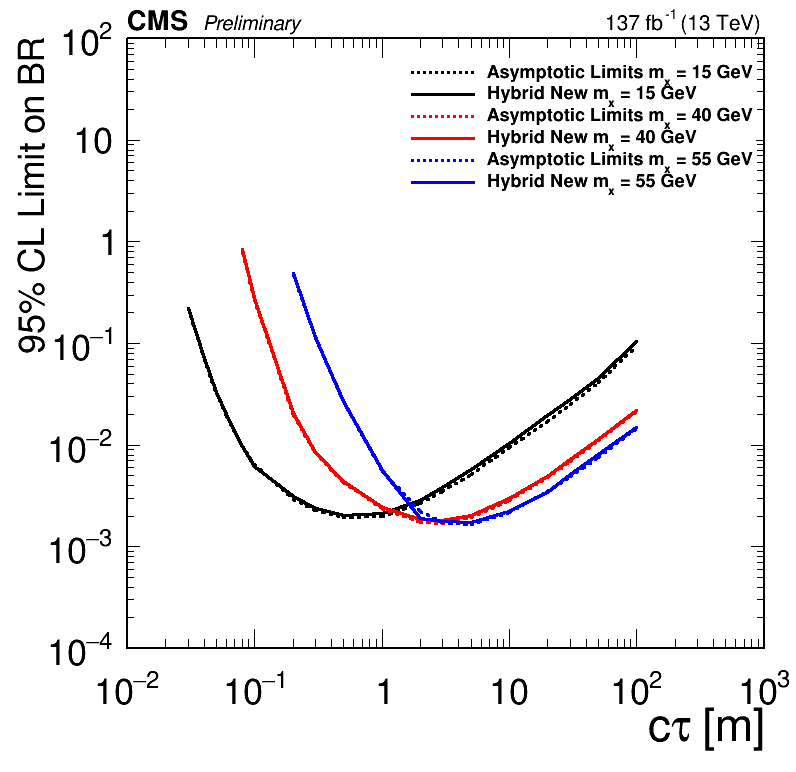

In [27]:
import os
opac_1sig = 0.25
opac_2sig = 0.1

for band in [0,1,2]:# 0 is no band, 1 is with 1sig only, 2 is with both 1sig and 2sig band
    if not band == 1:continue
    if band ==2: 
        leg = rt.TLegend(0.3,0.75,0.9,0.92)
        leg2 = rt.TLegend(0.1,0.75,0.3,0.90)
    elif band ==1: 
        leg = rt.TLegend(0.50,0.75,0.95,0.92)
        leg2 = rt.TLegend(0.18,0.77,0.40,0.90)
    else:
        leg = rt.TLegend(0.6,0.7,0.9,0.92)
        leg2 = rt.TLegend(0.2,0.7,0.45,0.92)
    
    
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    leg2.SetTextSize(0.025)
    leg2.SetBorderSize(0)
    leg2.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)


    rt.gStyle.SetOptFit(1011)
    ctaus_m = ctaus/1000
    print(ctaus_m)
    
    h_obs_hn = {}
    h_obs_as = {}
    h_exp_as = {}
    for i, m in enumerate(mass):
        cond = limits_hybridNew[m][:,2] < 1
    #     if m == 15: cond = np.logical_and(cond, ctaus_m<100)
        print_cond = np.logical_or(np.logical_or(np.logical_or(ctaus_m==0.1, ctaus_m==1), ctaus_m == 10),ctaus_m == 100)
        print(m, ctaus_m[print_cond])
        index = 5
        print(limits_hybridNew[m][:,index][print_cond]/limits[m][:,index][print_cond])
        h_obs_hn[m] = create_TGraph(ctaus_m[cond], limits_hybridNew[m][:,index][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
        h_obs_as[m] = create_TGraph(ctaus_m[cond], limits[m][:,index][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
#         h_exp_as[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])


        leg.AddEntry(h_obs_as[m], "Asymptotic Limits m_{x} = "+str(m)+" GeV", "L")
        leg.AddEntry(h_obs_hn[m], "Hybrid New m_{x} = "+str(m)+" GeV", "L")

#         if m == 15:
#             leg2.AddEntry(h_obs[m], "Observed Limit", "LP")
#             leg2.AddEntry(h[m], "Medium Expected Limit", "L")

        if len(mass) == 3: 
            h_obs_as[m].SetLineColor(std_color_list[i])
            h_obs_as[m].SetMarkerColor(std_color_list[i])
            h_obs_hn[m].SetLineColor(std_color_list[i])
            h_obs_hn[m].SetMarkerColor(std_color_list[i])
        else: 
            if i == 0:
                h_obs_as[m].SetLineColor(std_color_list[3])
                h_obs_as[m].SetMarkerColor(std_color_list[3])
                h_obs_hn[m].SetLineColor(std_color_list[3])
                h_obs_hn[m].SetMarkerColor(std_color_list[3])
            else: 
                h_obs_as[m].SetLineColor(std_color_list[i-1])
                h_obs_as[m].SetMarkerColor(std_color_list[i-1])
                h_obs_hn[m].SetLineColor(std_color_list[i-1])
                h_obs_hn[m].SetMarkerColor(std_color_list[i-1])
        h_obs_hn[m].SetLineWidth(3)
        h_obs_hn[m].SetMarkerStyle(20)
        h_obs_hn[m].SetMarkerSize(1)

        h_obs_as[m].SetLineStyle(2)
        h_obs_as[m].SetLineWidth(3)
        h_obs_as[m].GetXaxis().SetLimits(0.01,1000.0)
        h_obs_as[m].GetYaxis().SetRangeUser(1e-4,100)
        h_obs_as[m].GetXaxis().SetTitleOffset(1)
        h_obs_as[m].GetYaxis().SetTitleSize(0.05)
        h_obs_as[m].GetYaxis().SetTitleOffset(1.5)
        
        

    for i,m in enumerate(h_obs_as.keys()):
        h_obs_as[m].Draw('LA' if i == 0 else 'Lsame')
        h_obs_hn[m].Draw('Lsame')
      

 

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"

    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 4, iPos)

    leg.Draw()
    leg2.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
#     output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
#     if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)
#     if hybridNew:name += '_hybridNew'
#     if band==2: name += '_with2sig'
#     elif band>0: name += '_with1sig'



        
#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')

    tdrstyle.setTDRStyle()
    c.Draw()
    # print(time.time()-start_t)